In [1]:
import pandas as pd
import re
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ast

In [2]:
df=pd.read_csv("anuncios_completo.csv")

In [3]:
def limpiar_financiacion(df):
    df['financiacion_disponible'] = df['precio_financiado'].notna().astype(bool)
    if 'precio_financiado' in df.columns:
        df.drop(columns=['precio_financiado'], inplace=True)
    return df

df=limpiar_financiacion(df)


In [4]:
def limpiar_precio_y_descuento(df):
    df = df.copy()
    df['precio_contado'] = df['precio_contado'].str.replace('Al contado', '', regex=False).str.strip()
    df = df[~df['precio_contado'].isin(['Consultar-100%', 'Consultar'])]

    df['descuento'] = df['precio_contado'].str.extract(r'€\s*(.+)$', expand=False).fillna('')
    df['precio_contado'] = df['precio_contado'].str.replace(r'€\s*.+$', '€', regex=True).str.strip()
    df['descuento'] = df['descuento'].replace('', '0%')
    df['descuento_num'] = df['descuento'].str.replace('%', '', regex=False).astype(float) / 100

    df['precio_contado'] = df['precio_contado'].str.replace('€', '', regex=False)
    df['precio_contado'] = df['precio_contado'].str.replace('.', '', regex=False).str.strip()
    df['precio_contado'] = pd.to_numeric(df['precio_contado'], errors='coerce')

    df['precio'] = df['precio_contado'] * (1 + df['descuento_num'])
    df = df.rename(columns={'precio': 'precio_final'})

    df = df.drop(columns=['descuento'])
    df = df.rename(columns={'descuento_num': 'descuento'})
    df['precio_contado'] = df['precio_contado'].astype(float)

    return df

df = limpiar_precio_y_descuento(df)


In [5]:
def limpiar_tags(df):
    df = df.copy()

    df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    df['ubicacion'] = df['tags'].apply(lambda x: x[-1] if isinstance(x, list) and len(x) > 0 else None)
    df['kilometraje'] = df['tags'].apply(lambda x: x[-2] if isinstance(x, list) and len(x) > 1 else None)

    df['kilometraje'] = (
        df['kilometraje']
        .str.replace('.', '', regex=False)
        .str.replace(' km', '', regex=False)
        .astype(float)
    )

    def extraer_combustible(tag_list):
        if isinstance(tag_list, list) and len(tag_list) >= 3:
            posible_combustible = tag_list[-3]
            if not posible_combustible.isdigit() or len(posible_combustible) != 4:
                return posible_combustible
        return None

    df['combustible'] = df['tags'].apply(extraer_combustible)
    df = pd.get_dummies(df, columns=['combustible'], prefix='combustible', dummy_na=True)

    df['es_km0'] = df['tags'].apply(lambda x: 'Km0' in x if isinstance(x, list) else False)
    df['es_demo'] = df['tags'].apply(lambda x: 'Demo' in x if isinstance(x, list) else False)

    df.drop(columns=['tags'], inplace=True)

    return df

df = limpiar_tags(df)



In [6]:
coords = {
    'Madrid': (40.4168, -3.7038),
    'Barcelona': (41.3851, 2.1734),
    'Alicante': (38.3452, -0.4810),
    'Vizcaya': (43.2630, -2.9349),
    'Islas Baleares': (39.6953, 3.0176),
    'Málaga': (36.7213, -4.4214),
    'Castellón': (39.9864, -0.0513),
    'Valencia': (39.4699, -0.3763),
    'Tenerife': (28.2916, -16.6291),
    'Álava': (42.8584, -2.6726),
    'Badajoz': (38.8794, -6.9707),
    'Granada': (37.1773, -3.5986),
    'Cáceres': (39.4764, -6.3720),
    'Córdoba': (37.8882, -4.7794),
    'La Coruña': (43.3623, -8.4115),
    'Asturias': (43.3619, -5.8494),
    'Pontevedra': (42.4333, -8.65),
    'Zaragoza': (41.6488, -0.8891),
    'Sevilla': (37.3891, -5.9845),
    'Valladolid': (41.6523, -4.7245),
    'Toledo': (39.8628, -4.0273),
    'Las Palmas': (28.1235, -15.4363),
    'Cádiz': (36.5271, -6.2886),
    'Segovia': (40.9429, -4.1086),
    'Girona': (41.9794, 2.8214),
    'Tarragona': (41.1189, 1.2445),
    'Palencia': (42.0091, -4.5286),
    'Cantabria': (43.1828, -3.9871),
    'Ciudad Real': (38.9862, -3.9274),
    'Lleida': (41.6176, 0.6200),
    'Guipúzcoa': (43.2570, -2.9231),
    'León': (42.5987, -5.5671),
    'Orense': (42.3374, -7.8636),
    'Ávila': (40.6565, -4.6818),
    'Huelva': (37.2614, -6.9447),
    'Lugo': (43.0096, -7.5560),
    'Salamanca': (40.9701, -5.6635),
    'Burgos': (42.3439, -3.6969),
    'Albacete': (38.9943, -1.8564),
    'Almería': (36.8340, -2.4637),
    'Murcia': (37.9922, -1.1307),
    'La Rioja': (42.4627, -2.4450),
    'Cuenca': (40.0704, -2.1374),
    'Navarra': (42.6950, -1.6761),
    'Jaén': (37.7796, -3.7849),
    'Huesca': (42.1362, -0.4089),
    'Zamora': (41.5033, -5.7431),
    'Guadalajara': (40.6333, -3.1667),
    'Soria': (41.7636, -2.4666),
    'Teruel': (40.3449, -1.1066),
    'Melilla': (35.2923, -2.9381),
    'Ceuta': (35.8894, -5.3213)
}

df['latitud'] = df['ubicacion'].map(lambda x: coords.get(x, (None, None))[0])
df['longitud'] = df['ubicacion'].map(lambda x: coords.get(x, (None, None))[1])

In [7]:
def limpiar_detalles_ficha(df):
    def extraer_detalles(detalles):
        transmision = garantia = tipo_carroceria = asientos = potencia = puertas = mes = año = np.nan
        if isinstance(detalles, list):
            for item in detalles:
                if isinstance(item, str):
                    if 'Automático' in item or 'Manual' in item:
                        transmision = item
                    elif 'Garantía:' in item:
                        garantia = item.replace('Garantía:', '').strip()
                    elif item in ['Berlina', 'Todo Terreno', 'Stationwagon', 'Monovolumen', 'SUV', 'Coupé',
                                  'Deportivo', 'Familiar', 'Pickup', '4x4', 'Pequeño', 'Descapotable', 'Sedán', 'Hatchback']:
                        tipo_carroceria = item
                    elif 'asientos' in item.lower():
                        asientos = int(re.search(r'\d+', item).group()) if re.search(r'\d+', item) else np.nan
                    elif 'cv' in item.lower():
                        potencia = int(re.search(r'\d+', item).group()) if re.search(r'\d+', item) else np.nan
                    elif 'Puertas' in item:
                        puertas = int(re.search(r'\d+', item).group()) if re.search(r'\d+', item) else np.nan
                    elif 'Matriculado:' in item:
                        fecha = item.replace('Matriculado:', '').strip()
                        if '/' in fecha:
                            mes, año = fecha.split('/')
                            mes = int(mes)
                            año = int(año)
        return pd.Series([transmision, garantia, tipo_carroceria, asientos, potencia, puertas, mes, año])

    df['detalles_ficha'] = df['detalles_ficha'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    columnas_nuevas = ['transmision', 'garantia', 'tipo_carroceria', 'asientos', 'potencia', 'puertas',
                       'mes_matriculacion2', 'año_matriculacion2']
    df[columnas_nuevas] = df['detalles_ficha'].apply(extraer_detalles)

    df.drop(columns=['detalles_ficha'], inplace=True, errors='ignore')

    return df

df = limpiar_detalles_ficha(df)


In [8]:
def limpiar_columna_plazo(col):
    col = col.fillna('0').replace({'No': '0'})
    moda = col[col.str.contains('meses', na=False)].mode()[0]
    col = col.replace({'Sí': moda})
    col = col.str.replace('meses', '', regex=False).str.strip().astype(int)
    return col

df['garantia_limpia'] = limpiar_columna_plazo(df['garantia'])

df.drop(columns=['garantia'], inplace=True)

In [9]:
def limpieza_final(df):
    df['transmision'] = df['transmision'].fillna('Automático')

    df['tipo_carroceria'] = df['tipo_carroceria'].fillna('Desconocido')
    df['asientos'] = df['asientos'].fillna(0)
    df['potencia'] = df['potencia'].fillna(0)

    mediana_año = df['año_matriculacion2'].median()
    df['año_matriculacion2'] = df['año_matriculacion2'].fillna(mediana_año)

    mediana_mes = df['mes_matriculacion2'].median()
    df['mes_matriculacion2'] = df['mes_matriculacion2'].fillna(mediana_mes)

    moda_puertas = df['puertas'].mode()[0]
    df['puertas'] = df['puertas'].fillna(moda_puertas)
    
    return df

df = limpieza_final(df)


In [10]:
def limpiar_transmision(df):
    df = df.copy()
    df['transmision'] = df['transmision'].apply(lambda x: 'Automático' if 'Automático' in str(x) else x)
    
    return df

df = limpiar_transmision(df)

In [11]:
def extra(df):
    df.drop(columns=['url'], inplace=True)
    
    mediana = df[df['garantia_limpia'] <= 120]['garantia_limpia'].median()
    df.loc[df['garantia_limpia'] > 120, 'garantia_limpia'] = mediana

    df.reset_index(drop=True, inplace=True)

    df.to_csv('datos_limpios.csv', index=False)
    
    return df

df = extra(df)



In [12]:
df['timestamp_extraccion'] = pd.to_datetime(df['timestamp_extraccion'], errors='coerce')


In [13]:
df

,id_extraccion,timestamp_extraccion,marca,titulo,precio_contado,financiacion_disponible,descuento,precio_final,ubicacion,kilometraje,...,latitud,longitud,transmision,tipo_carroceria,asientos,potencia,puertas,mes_matriculacion2,año_matriculacion2,garantia_limpia
0,https://www.autocasion.com/coches-segunda-mano...,2025-06-13 17:48:32.862597,ABARTH,ABARTH 500 C 695C 1.4 16v T-Jet 132kW (180 CV),22490.0,True,-0.04,21590.40,Madrid,23213.0,...,40.4168,-3.7038,Manual,Desconocido,0.0,179.0,2.0,12.0,2022.0,12
1,https://www.autocasion.com/coches-segunda-mano...,2025-06-13 17:48:32.863158,ABARTH,"ABARTH 500 1,4 Turbo",11799.0,True,-0.03,11445.03,Barcelona,100924.0,...,41.3851,2.1734,Manual,Desconocido,0.0,135.0,3.0,4.0,2015.0,12
2,https://www.autocasion.com/coches-segunda-mano...,2025-06-13 17:48:32.863594,ABARTH,ABARTH 124 SPIDER Spider Turbo Multiair 125kW...,22990.0,True,-0.04,22070.40,Barcelona,97814.0,...,41.3851,2.1734,Automático,Desconocido,2.0,170.0,2.0,12.0,2018.0,12
3,https://www.autocasion.com/coches-segunda-mano...,2025-06-13 17:48:32.863992,ABARTH,ABARTH 500 595 1.4T JET TURISMO 160,15990.0,True,0.00,15990.00,Alicante,36000.0,...,38.3452,-0.4810,Manual,Berlina,4.0,160.0,3.0,10.0,2016.0,12
4,https://www.autocasion.com/coches-segunda-mano...,2025-06-13 17:48:32.864370,ABARTH,ABARTH 500 500C 140 AUT.,13600.0,False,-0.07,12648.00,Vizcaya,145800.0,...,43.2630,-2.9349,Automático,Desconocido,4.0,140.0,2.0,7.0,2012.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109060,https://www.autocasion.com/coches-km0/km-0/yud...,2025-06-13 21:34:25.203449,YOOUDOOO,YOOUDOOO K3 70kW,19990.0,True,0.00,19990.00,Pontevedra,7361.0,...,42.4333,-8.6500,Automático,Todo Terreno,5.0,95.0,5.0,6.0,2024.0,24
109061,https://www.autocasion.com/coches-km0/km-0/yud...,2025-06-13 21:34:25.203631,YOOUDOOO,YOOUDOOO K3 70kW,21900.0,True,0.00,21900.00,Sevilla,3000.0,...,37.3891,-5.9845,Automático,Todo Terreno,5.0,95.0,5.0,7.0,2024.0,96
109062,https://www.autocasion.com/coches-km0/km-0/yud...,2025-06-13 21:34:25.203813,YOOUDOOO,YOOUDOOO K3 YUDO Pequeño Automático de 5 Puertas,26838.0,True,0.00,26838.00,Barcelona,10.0,...,41.3851,2.1734,Automático,Pequeño,5.0,95.0,5.0,8.0,2024.0,12
109063,https://www.autocasion.com/coches-km0/km-0/yud...,2025-06-13 21:34:25.204043,YOOUDOOO,YOOUDOOO K3 70kW,22990.0,True,0.00,22990.00,La Rioja,4585.0,...,42.4627,-2.4450,Automático,Todo Terreno,5.0,95.0,5.0,1.0,2025.0,84


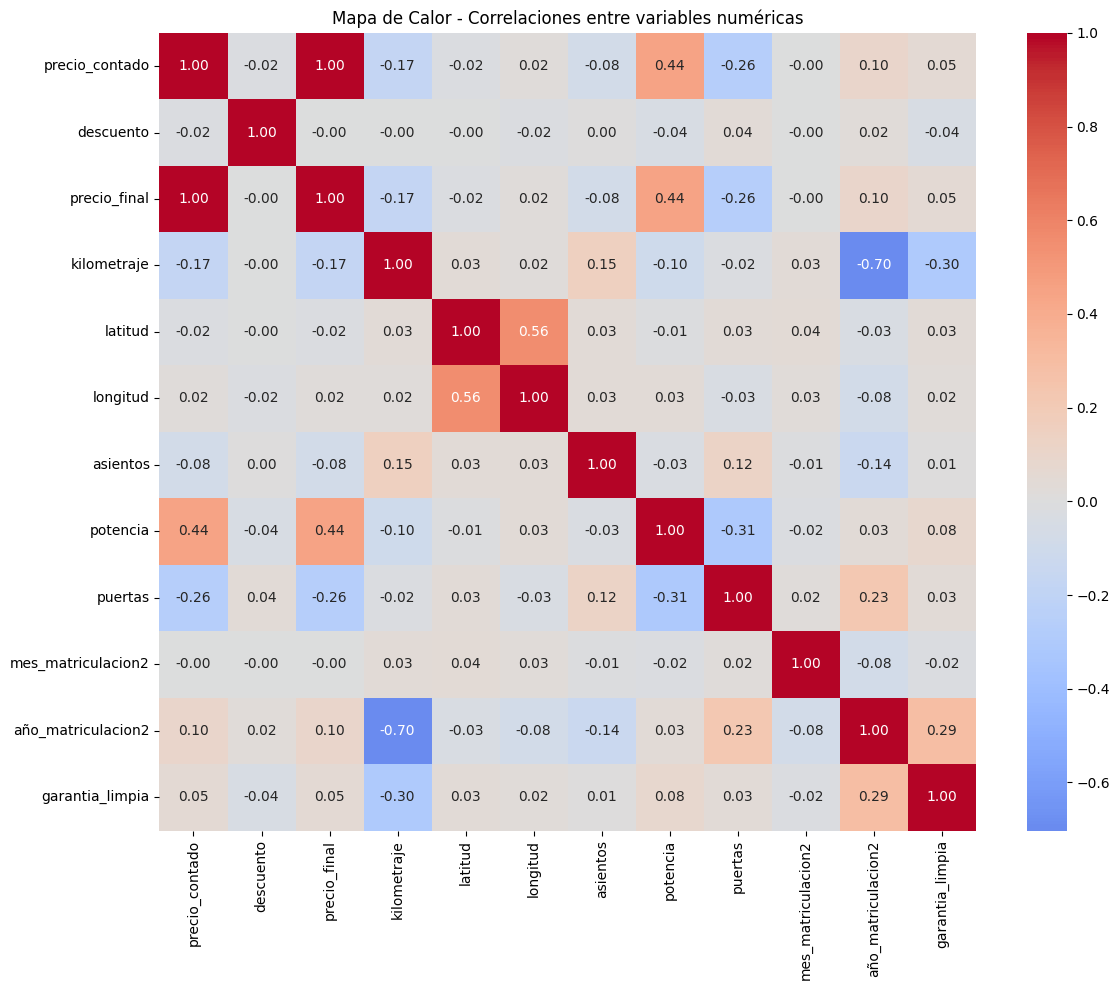

In [14]:
numeric_cols = df.select_dtypes(include=np.number)

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Mapa de Calor - Correlaciones entre variables numéricas')
plt.tight_layout()
plt.show()

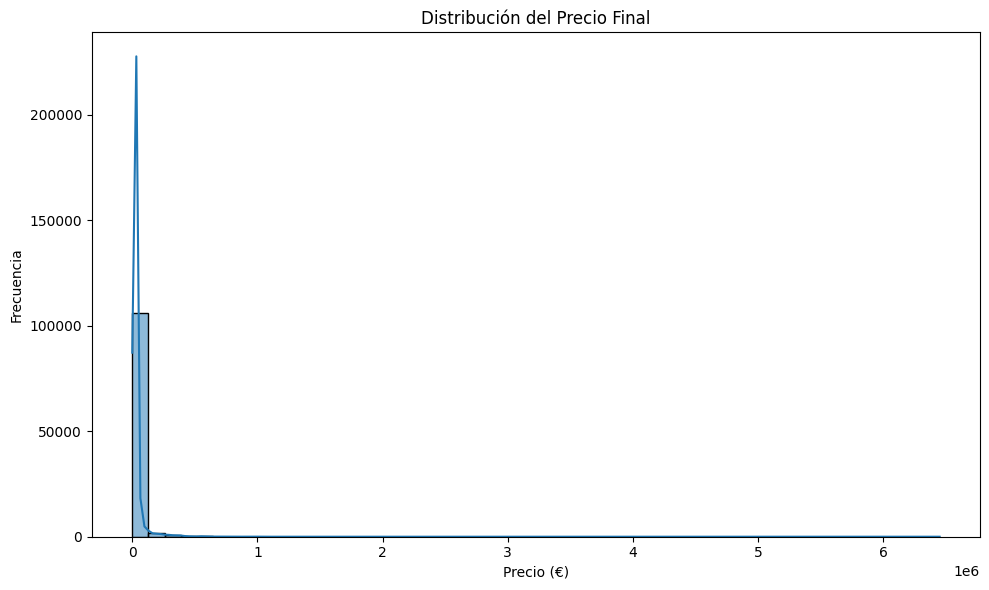

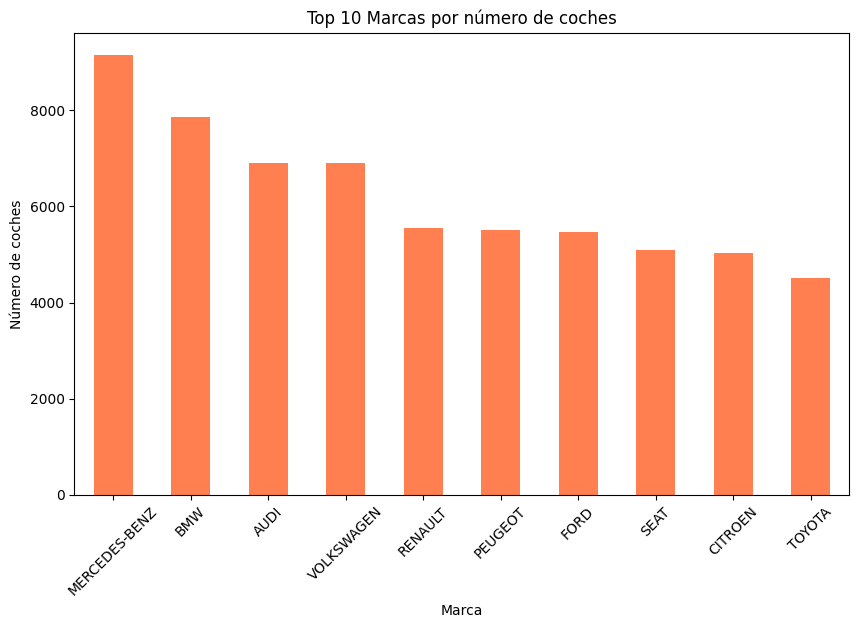

In [15]:
plt.figure(figsize=(10,6))
sns.histplot(df['precio_final'], bins=50, kde=True)
plt.title('Distribución del Precio Final')
plt.xlabel('Precio (€)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


top_marcas = df['marca'].value_counts().nlargest(10)
plt.figure(figsize=(10,6))
top_marcas.plot(kind='bar', color='coral')
plt.title('Top 10 Marcas por número de coches')
plt.xlabel('Marca')
plt.ylabel('Número de coches')
plt.xticks(rotation=45)
plt.show()

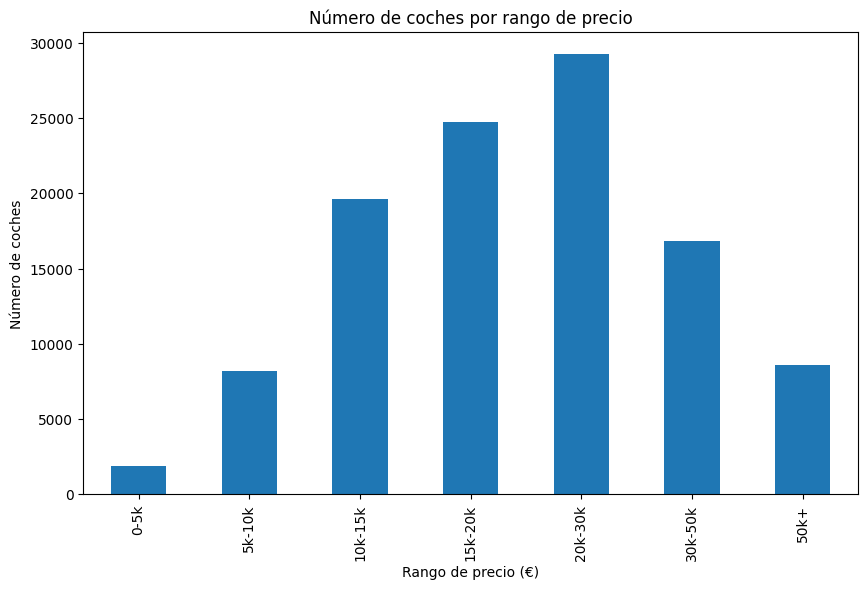

In [16]:
bins = [0, 5000, 10000, 15000, 20000, 30000, 50000, df['precio_final'].max()]
labels = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-30k', '30k-50k', '50k+']

df['precio_rango'] = pd.cut(df['precio_final'], bins=bins, labels=labels, include_lowest=True)


frecuencias = df['precio_rango'].value_counts().sort_index()

plt.figure(figsize=(10,6))
frecuencias.plot(kind='bar')
plt.title('Número de coches por rango de precio')
plt.xlabel('Rango de precio (€)')
plt.ylabel('Número de coches')
plt.show()


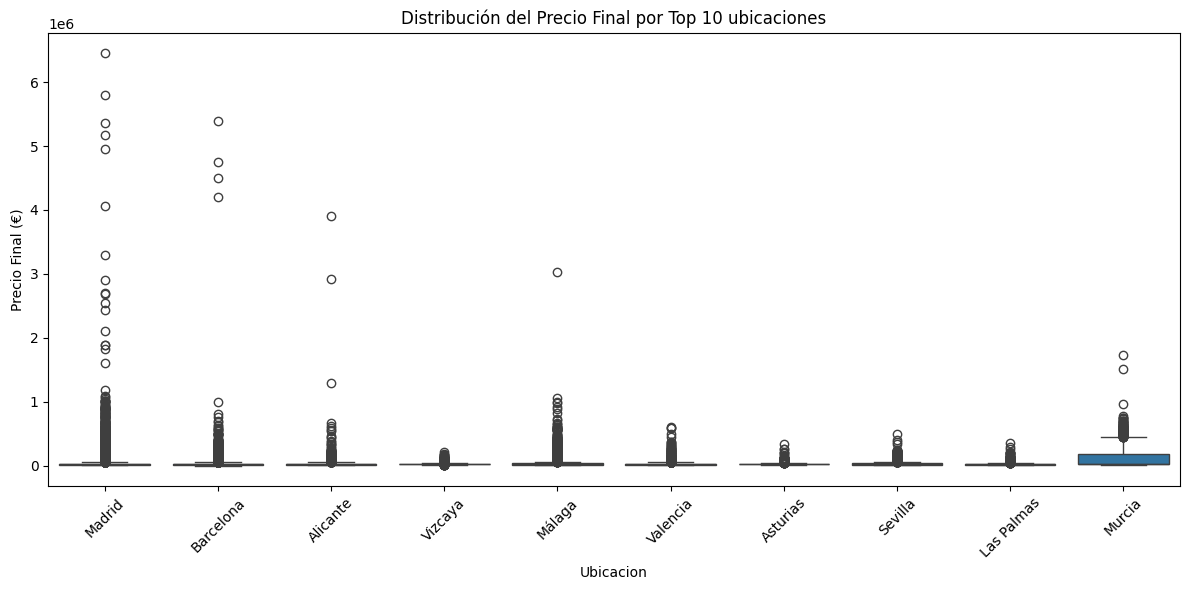

In [17]:
top_ubicacion = df['ubicacion'].value_counts().nlargest(10).index
df_top = df[df['ubicacion'].isin(top_ubicacion)]

plt.figure(figsize=(12,6))
sns.boxplot(data=df_top, x='ubicacion', y='precio_final')
plt.title('Distribución del Precio Final por Top 10 ubicaciones')
plt.xlabel('Ubicacion')
plt.ylabel('Precio Final (€)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



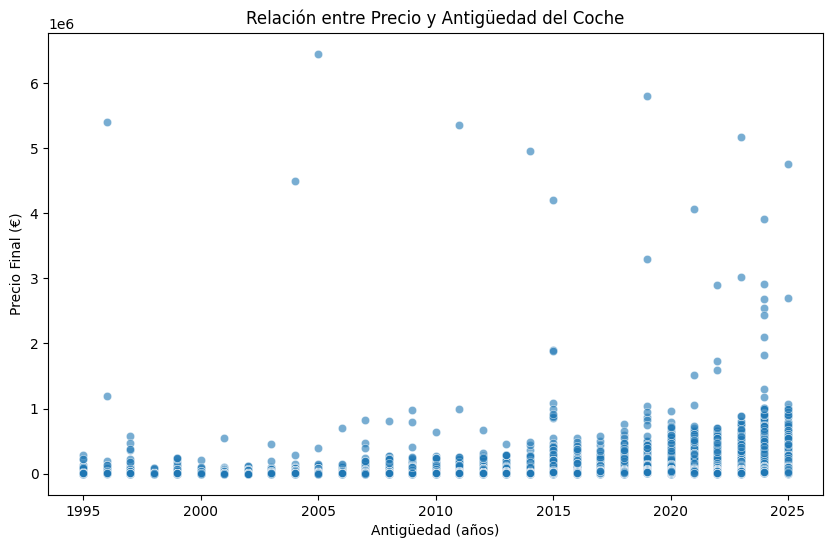

In [18]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='año_matriculacion2', y='precio_final', alpha=0.6)
plt.title('Relación entre Precio y Antigüedad del Coche')
plt.xlabel('Antigüedad (años)')
plt.ylabel('Precio Final (€)')
plt.show()


In [19]:
df['log_precio'] = np.log1p(df['precio_final'])


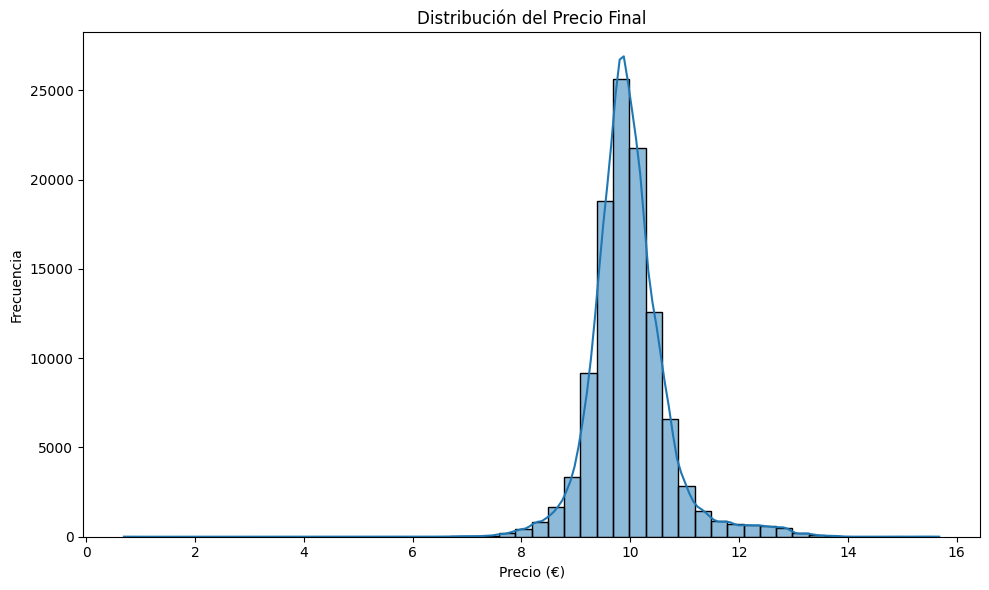

In [20]:
plt.figure(figsize=(10,6))
sns.histplot(df['log_precio'], bins=50, kde=True)
plt.title('Distribución del Precio Final')
plt.xlabel('Precio (€)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

In [21]:
fig = px.box(df_top, x='ubicacion', y='precio_final', title='Precio segun las top 10 ubicaciones')
fig.show()
